# Ridership on Amtrak

### Import required packages and dataset

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

In [2]:
#Load, convert Amtrak data for time series analysis
Amtrak_df = pd.read_csv('Amtrak.csv', squeeze=True)

C:\Users\haleh\AppData\Local\Temp\ipykernel_17472\1948882357.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  Amtrak_df = pd.read_csv('Amtrak.csv', squeeze=True)


In [3]:
#Create column 'Date' that is a date data type
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
Amtrak_df.head(9)

,Month,Ridership,Date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01
5,01/06/1991,1862.356,1991-06-01
6,01/07/1991,1939.860,1991-07-01
7,01/08/1991,2013.264,1991-08-01
8,01/09/1991,1595.657,1991-09-01


Text(0, 0.5, 'Ridership (in 000s)')

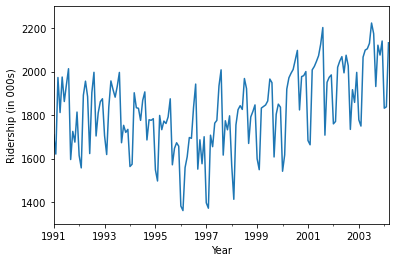

In [4]:
#Plot ridership by year
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date)
ridership_ts.plot(ylim=[1300, 2300], legend=False)
plt.xlabel('Year'); plt.ylabel('Ridership (in 000s)')

### Linear trend

In [5]:
#load data and convert to time series
Amtrak_df = pd.read_csv('Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, name='Ridership', index=Amtrak_df.Date)

In [6]:
#Fit a linear trend model to the time series
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()
print(ridership_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     32.92
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           4.80e-08
Time:                        22:27:01   Log-Likelihood:                -1037.1
No. Observations:                 159   AIC:                             2078.
Df Residuals:                     157   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1690.7983     26.401     64.042      0.0

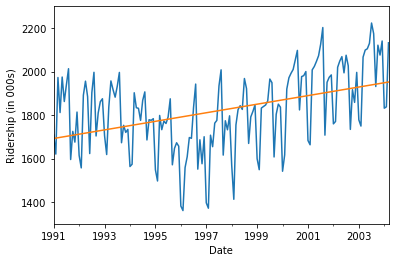

In [7]:
#Plot the time series
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
ridership_lm.predict(ridership_df).plot(ax=ax)
plt.show()


In [8]:
#Slpit the dataset to train, valild, test
train_df, valid_df, test = np.split(ridership_df.sample(frac=1), [int(.6*len(ridership_df)), int(.8*len(ridership_df))])

In [9]:
#Fit a linear model using the training set and predict on the validation set
ridership_lm = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df = ridership_lm.predict(valid_df)

In [10]:
#Implementation
def singleGraphLayout(ax, ylim, train_df, valid_df):
 ax.set_xlim('1990', '2004-6')
 ax.set_ylim(*ylim)
 ax.set_xlabel('Time')
 one_month = pd.Timedelta('31 days')
 xtrain = (min(train_df.index), max(train_df.index) - one_month)
 xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
 xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
 ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
 ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black',linewidth=0.5))
 ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black',linewidth=0.5))
 ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
 ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
 ax.text('1995', ypos, 'Training')
 ax.text('2002-3', ypos, 'Validation')

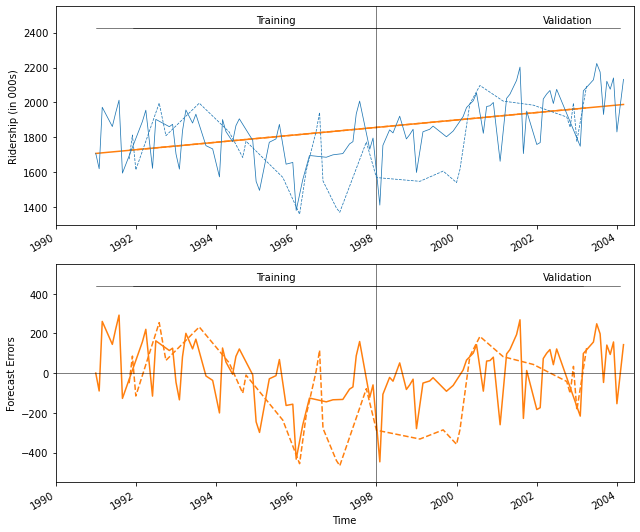

In [11]:
#Implementation
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed',
        linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend():
     axes[0].get_legend().remove()
    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_lm.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
residual = train_df.Ridership - ridership_lm.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

In [12]:
#Linear trend summary
ridership_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     27.54
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           9.64e-07
Time:                        22:27:05   Log-Likelihood:                -612.32
No. Observations:                  95   AIC:                             1229.
Df Residuals:                      93   BIC:                             1234.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1706.5849     32.047     53.252      0.000    1642.945    1770.225
trend          1.7741      0.338      5.248      0.000       1.103       2.445
==============================================================================
Omnibus:                        3.946   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.676
Skew:                          -0.482   Prob(JB):                        0.159
Kurtosis:                       2.994   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Exponential Trend

In [13]:
#Fit the exponential trend model, make predictions:
ridership_lm_linear = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df_linear = ridership_lm_linear.predict(valid_df)
ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()
predict_df_expo = ridership_lm_expo.predict(valid_df)

In [14]:
predict_df_expo

Date
1996-09-01    7.507312
1994-10-01    7.485638
2002-12-01    7.577988
1992-01-01    7.454541
2001-12-01    7.566680
2000-08-01    7.551603
1991-12-01    7.453599
1998-01-01    7.522390
2000-05-01    7.548776
1991-11-01    7.452656
1997-01-01    7.511082
2002-11-01    7.577046
2003-04-01    7.581758
1994-09-01    7.484696
1996-08-01    7.506370
1999-02-01    7.534640
1997-10-01    7.519563
1997-02-01    7.512024
1992-10-01    7.463022
1992-08-01    7.461137
1993-08-01    7.472446
1994-05-01    7.480927
2002-10-01    7.576104
1996-04-01    7.502601
2003-01-01    7.578931
1995-09-01    7.496004
1996-07-01    7.505428
2000-02-01    7.545949
2000-01-01    7.545006
2001-03-01    7.558199
1999-09-01    7.541237
1996-02-01    7.500716
dtype: float64

### Polynomial Trend

In [15]:
#Fit the polynomial trend model, make predictions:
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)',data=train_df).fit()
predict_df_poly = ridership_lm_poly.predict(valid_df)

In [16]:
predict_df_poly

Date
1996-09-01    1757.543496
1994-10-01    1753.833384
2002-12-01    2025.496054
1992-01-01    1812.839277
2001-12-01    1956.307196
2000-08-01    1879.650317
1991-12-01    1815.810879
1998-01-01    1781.845957
2000-05-01    1867.261329
1991-11-01    1818.852100
1997-01-01    1761.948226
2002-11-01    2019.347404
2003-04-01    2050.786854
1994-09-01    1754.507518
1996-08-01    1756.616364
1999-02-01    1814.715121
1997-10-01    1775.931651
1997-02-01    1763.223459
1992-10-01    1789.227775
1992-08-01    1793.987434
1993-08-01    1769.606696
1994-05-01    1757.900254
2002-10-01    2013.268375
1996-04-01    1753.604039
2003-01-01    2031.714324
1995-09-01    1751.012850
1996-07-01    1755.758853
2000-02-01    1855.498924
2000-01-01    1851.717362
2001-03-01    1910.994664
1999-09-01    1837.287319
1996-02-01    1752.515598
dtype: float64

### Handling Seasonality

In [17]:
#Add seasonality
ridership_df = tsatools.add_trend(ridership_ts, trend='c')
ridership_df['Month'] = ridership_df.index.month

In [18]:
#Slpit the dataset to train, valild, test
train_df, valid_df, test = np.split(ridership_df.sample(frac=1), [int(.6*len(ridership_df)), int(.8*len(ridership_df))])

In [19]:
#Fit the linear trend model, make predictions:
ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()
predict_df_season = ridership_lm_season.predict(valid_df)

In [20]:
predict_df_season

Date
1991-05-01    1933.332250
1998-10-01    1865.796500
2000-08-01    2003.912889
1995-09-01    1718.367857
2002-05-01    1933.332250
1993-10-01    1865.796500
1998-05-01    1933.332250
1994-05-01    1933.332250
1994-01-01    1625.444900
1997-02-01    1580.903444
1994-09-01    1718.367857
1997-04-01    1950.020750
2002-06-01    1873.237625
2000-11-01    1820.017444
1992-06-01    1873.237625
2000-06-01    1873.237625
1996-04-01    1950.020750
1996-01-01    1625.444900
1998-09-01    1718.367857
1996-10-01    1865.796500
1998-07-01    2001.006857
1999-10-01    1865.796500
1995-11-01    1820.017444
1994-12-01    1792.823800
1995-05-01    1933.332250
1992-07-01    2001.006857
1993-12-01    1792.823800
1997-10-01    1865.796500
1994-04-01    1950.020750
2001-12-01    1792.823800
1999-02-01    1580.903444
1993-06-01    1873.237625
dtype: float64